In [1]:
from transformers import BertTokenizer, TFBertForSequenceClassification

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from torch import nn
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
import torch
from torch.utils.data import DataLoader
from transformers import BertModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import re


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import glob
file_names = glob.glob('/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/*.csv')
print(file_names)

Mounted at /content/drive
['/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CNN_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCFLu_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCtravel_tweets_unique_.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCemergency_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCgov_tweets_unique.csv']


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_data = []
for file_name in file_names:
    temp = pd.read_csv(file_name)
    if 'CDCFLu' in file_name:
        temp = temp.head(50)
    else:
        temp = temp.head(499)
    df_data.append(temp)

In [6]:
df_data = pd.concat(df_data)

In [7]:
print(df_data.shape)

(2046, 13)


In [8]:
print(df_data["Category"].unique())

[nan 'Outbreak' 'Vaccine; Outbreak' 'Outbreak; Prevention; Vaccine'
 'Outbreak; Vaccine' 'Outbreak; Symptoms' 'Outbreak; Prevention' 'Vaccine'
 'Prevention' 'Outbreak; Vaccine; Prevention' 'Vaccine; Prevention'
 'Vaccine, Prevention; Symptoms' 'Vaccine, Outbreak' 'Travel; Outbreak'
 'Travel' 'Prevention, Travel' 'Travel; Prevention' 'Prevention; Travel'
 'Symptoms' 'Prevention; Outbreak' 'Prevention: Travel'
 'Prevention; travel' 'Prevntion' 'Outbreak ' 'Vaccine, Travel'
 'Outbreak; Travel' 'outbreak' 'Travel; prevention' 'Travel; Symptoms'
 'Ountbreak' 'outbreak ' 'prevention' ' Outbreak; Prevention'
 ' Prevention' 'Outbrek; Symptoms' 'Outbreak; symptoms'
 'Outbreak; prevention' 'prevention; outbreak' 'Prevention; Outbreak '
 'Outbreak Prevention' 'outbreak, prevention' 'Prevention; outbreak'
 'outbreak; prevention' 'travel; prevention' 'Symptoms; Prevention'
 'Prevention, Outbreak' 'Outbreak; Awarness' 'Prevention; Awarness'
 'Symptoms, Awarness' 'Outbreak;Awareness' 'Outbreak; reaso

In [9]:
def clean_text(text):
    text = re.sub(r'RT\s@\w+:\s', '', text) # remove retweet text
    text = re.sub(r'https?:\/\/\S+', '', text) # remove URLs
    text = re.sub(r'&\w+;', '', text) # remove HTML entities
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\W+', ' ', text) # remove special characters
    text = text.lower() # convert to lowercase
    return text

In [10]:
df_data["clean_text"] = df_data["text"].apply(clean_text)


# Filtering the rare terms.
df_data_filtered = df_data.groupby("Category").filter(lambda x: len(x) >1)
df_data_filtered.shape
print(df_data_filtered["Category"])
df_data_filtered["Category"]=[''.join(i.split()).lower() for i in df_data_filtered["Category"]]

2                  Outbreak
4                  Outbreak
12        Vaccine; Outbreak
28        Outbreak; Vaccine
39                 Outbreak
               ...         
487    Prevention; Awarness
488              Prevention
490                Symptoms
492              Prevention
496                Symptoms
Name: Category, Length: 938, dtype: object


In [11]:
def filter_category(categories):
  #options = ['travel', 'outbreak','prevention','vaccine','symptoms']
  if ',' in categories:
    category_list = categories.split(',')
  elif ';' in categories:
    category_list = categories.split(';')
  else:
    category_list = [categories]

  print(category_list)
  '''
  temp = []
  for item in category_list:
    item = item.strip().lower()
    if 'awarness' == item:
      continue
    temp.append(item.strip())
  #print('temp =', temp)
  '''
  return category_list

In [ ]:
df_data_filtered["Category"] = df_data_filtered["Category"].apply(filter_category)

labels=[item for item in df_data_filtered["Category"]]

In [13]:
mlb = MultiLabelBinarizer()
one_hot_encodings = mlb.fit_transform(labels)

pd.DataFrame(one_hot_encodings, columns=mlb.classes_)
final_text=[text for text  in df_data_filtered["clean_text"]]

In [14]:
labels=[lab for lab  in one_hot_encodings]

lab,c =np.unique(one_hot_encodings, axis=0, return_counts=True)

print(lab,c)
print(" ")
print(mlb.classes_)
print(" ")
print("total",sum(c))
print(" ")
print(final_text[0])
print(df_data_filtered.columns)

[[0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 1 0 1 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 1]
 [0 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 0]] [ 12 142  18 207   2  50   2 341  27   8  11 100   5  13]
 
['awarness' 'outbreak' 'prevention' 'symptoms' 'travel' 'vaccine']
 
total 938
 
b europe is now trading more goods with china than the united states a sign of how the pandemic is transforming the global economy the overall value of eu china goods trade last year was billion about billion more than between the eu and the us 
Index(['id', 'Account Created At(same for all rows)', 'status created_at',
       'Fav_cont', 'retweeted_count', 'reply_to_status', 'reply_to_screen',
       'quote', 'No', 'Category', 'text', 'Yes/No', 'Unnamed: 0',
       'clean_text'],
      dtype='object')


In [15]:
lnew=np.zeros((len(labels),5));
#print("before",labels)
for i,l in enumerate(labels):
  lnew[i,:]=l[1:]
final_label=lnew
print(final_label)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [16]:
len(final_text), len(lnew)

(938, 938)

In [17]:
type(final_text), type(lnew)

(list, numpy.ndarray)

In [42]:
# Define your BERT model class
class BERTClass(nn.Module):
    def __init__(self, num_classes):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(768, NUM_CLASSES)  # Output dimension changed to num_classes for multiclass classification

    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output['pooler_output']
        dropout_output = self.dropout(pooled_output)
        output = self.linear(dropout_output)
        return output

In [19]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# Define your CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'  # Return PyTorch tensors
        )

        # Convert label to tensor with long (int) dtype
        label_tensor = torch.tensor(label, dtype=torch.long)

        return {
            'input_ids': encoding['input_ids'].flatten(),  # Flatten the tensors
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label_tensor
        }

In [21]:
len(final_text), lnew.shape

(938, (938, 5))

In [30]:
# Hyperparameters
MAX_LEN = 20
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 20
EPOCHS = 5
LEARNING_RATE = 0.01

In [23]:
# Splitting the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(final_text, lnew, test_size=0.2, random_state=95, stratify=lnew)


In [24]:
# Initialize your BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create train and test datasets
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, MAX_LEN)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, MAX_LEN)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [25]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
NUM_CLASSES = 5

In [27]:
model = BERTClass(NUM_CLASSES)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [28]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)


#Define the loss_fn
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

# Define the accuracy function
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
# # Hyperparameters
# MAX_LEN = 20
# TRAIN_BATCH_SIZE = 20
# TEST_BATCH_SIZE = 20
# EPOCHS = 5
# LEARNING_RATE = 0.01


# Initialize lists to store loss and accuracy values
loss_values = []
accuracy_values = []

for epoch in range(1, EPOCHS + 1):
    model.train()  # Set the model to train mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate over the training dataset
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Move this line here

        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model(input_ids, attention_mask)
        outputs_softmax = F.softmax(outputs, dim=1)

        _, predicted_labels = torch.max(outputs, dim=1)  # Get the predicted class indices

        # Calculate loss
        loss = loss_fn(outputs_softmax, torch.argmax(labels, dim=1))
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Calculate accuracy
        _, predicted_labels = torch.max(outputs, dim=1)  # Get the index of the max log-probability
        correct_predictions += torch.eq(predicted_labels, torch.argmax(labels, dim=1)).sum().item()
        total_samples += labels.size(0)

    # Calculate accuracy for the epoch
    epoch_accuracy = correct_predictions / total_samples

    # Calculate average loss for the epoch
    epoch_loss = total_loss / len(train_loader)

    # Save loss and accuracy values
    loss_values.append(total_loss)
    accuracy_values.append(epoch_accuracy)

    print(f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.4f}%")

Epoch 1: Loss: 1.4561, Accuracy: 43.6000%
Epoch 2: Loss: 1.3706, Accuracy: 53.3333%
Epoch 3: Loss: 1.3706, Accuracy: 53.3333%
Epoch 4: Loss: 1.3706, Accuracy: 53.3333%
Epoch 5: Loss: 1.3706, Accuracy: 53.3333%


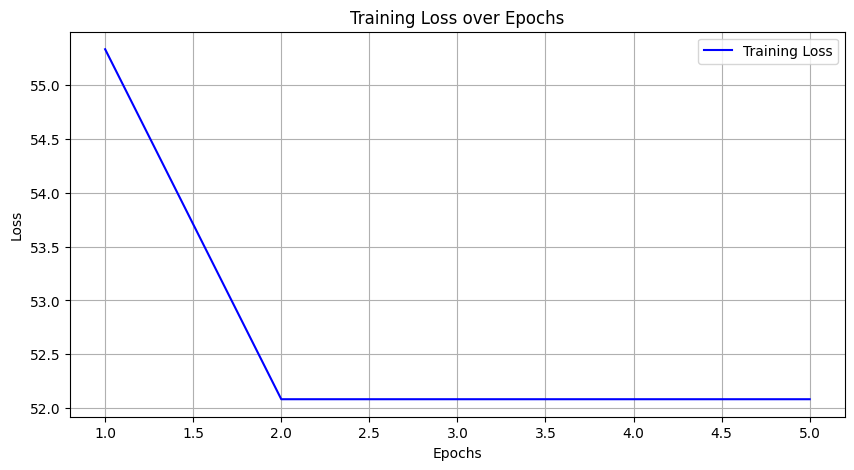

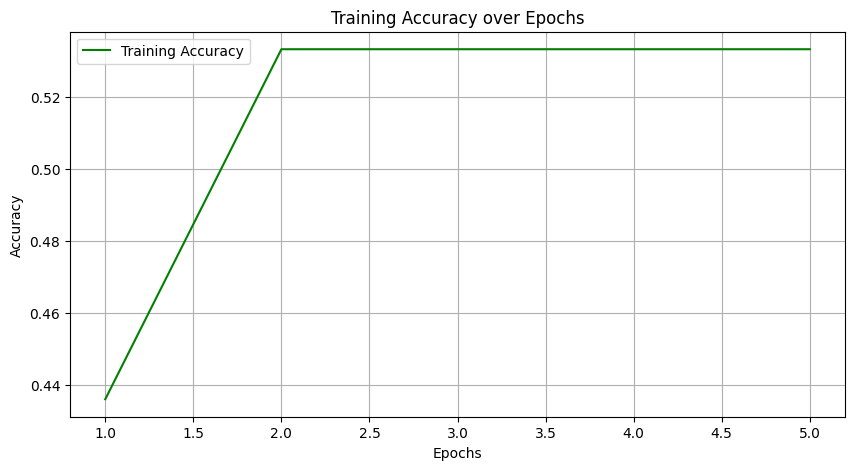

In [32]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), loss_values, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), accuracy_values, label='Training Accuracy', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
def eval_model(validation_loader, model, loss_fn):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_predictions = []
    all_targets = []

    # set model to eval mode
    model.eval()

    with torch.no_grad():
        for batch_idx, batch in enumerate(validation_loader, 0):
            inputs, targets = batch['input_ids'].to(device), batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(inputs, attention_mask)

            # Convert logits to probabilities
            probabilities = torch.sigmoid(outputs)

            # Calculate loss
            loss = loss_fn(probabilities, targets.float())
            losses.append(loss.item())

            # Compute correct predictions
            predicted_labels = (probabilities > 0.5).float()
            correct_predictions += (predicted_labels == targets).all(dim=1).sum().item()
            num_samples += targets.size(0)

            # Store predictions and targets
            all_predictions.append(predicted_labels.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate mean loss
    mean_loss = sum(losses) / len(losses)
    normalized_loss = mean_loss / (torch.tensor(losses).max())  # Normalizing to the maximum loss value

    # Calculate accuracy
    accuracy = correct_predictions / num_samples

    # Convert predictions and targets to numpy arrays
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate recall, precision, and F1 scores
    recall = recall_score(all_targets, all_predictions, average='micro')
    precision = precision_score(all_targets, all_predictions, average='micro')
    f1_micro = f1_score(all_targets, all_predictions, average='micro')
    f1_macro = f1_score(all_targets, all_predictions, average='macro')

    return accuracy, normalized_loss, recall, precision, f1_micro, f1_macro, all_predictions, all_targets


In [54]:
# Evaluate the model on the test data
test_accuracy, test_normalized_loss, test_recall, test_precision, test_f1_micro, test_f1_macro, all_predictions,all_targets = eval_model(test_loader, model, loss_fn)

In [57]:
# Print the evaluation metrics
print(f'Test Accuracy: {test_accuracy*100:.4f}%')
print(f'Test Loss: {test_normalized_loss*100}')
print(f'Test Recall: {test_recall*100}')
print(f'Test Precision: {test_precision*100}')
print(f'Test Micro-average F1-score: {test_f1_micro*100}')
print(f'Test Macro-average F1-score: {test_f1_macro*100}')

Test Accuracy: 10.6383%
Test Loss: 86.23367309570312
Test Recall: 76.2114537444934
Test Precision: 46.01063829787234
Test Micro-average F1-score: 57.37976782752903
Test Macro-average F1-score: 25.07662835249042


In [56]:
# Generate the classification report
report = classification_report(all_targets, all_predictions, labels=[0, 1], target_names=['Class 0', 'Class 1'], zero_division=1)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.53      1.00      0.69       100
     Class 1       0.39      1.00      0.56        73

   micro avg       0.46      1.00      0.63       173
   macro avg       0.46      1.00      0.63       173
weighted avg       0.47      1.00      0.64       173
 samples avg       0.46      1.00      0.58       173

